In [329]:
#bibliotecas padrão 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas_profiling as pf 

sns.set()

#skelarn preprocessing 

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer  

#tensforflow model 
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

#vizualizer 

from keras.utils import plot_model


Este estudo teórico visa identificar o potencial de previsão de modelos de Deep Learning construídos sobre Redes Neurais (Neural Networks) em bases de dados de crédtio bancário. 

Vale ressaltar que nenhuma informação contida neste documento é real, e portanto, não deve ser levada em conta para se tomar qualquer tipo de decisão de negócios. A base de dados foi disponibilizada abertamento pelo usuário 'LaoTse' no portal Keagle  

Link: https://www.kaggle.com/datasets/laotse/credit-risk-dataset?select=credit_risk_dataset.csv

-------------------------

*Passo 1 - Importar a base de Dados*

Neste primeiro passo, deve-se importar os dados fornecidos em csv e obter uma visualização prévia de como as informações continuas no arquivo estão dispostas. Para isso utilizaremos o 'Pandas Profiling' que é uma ferramenta muito útil para sumarizar Dataframes compilados no pandas

In [284]:
credit_data = pd.read_csv('credit_risk_dataset.csv')

In [285]:
#profiling data 

profile = pf.ProfileReport(credit_data, title = 'Credit Dataset Profile')
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Pode-se perceber, com a base de alertas, que algumas colunas apersentam dados ausentes, o que pode gerar ruídos nas previsões do modelo. Como boa prática, recomenda-se tratar esses dados ausentes e demais problemas que iremos encontrar ao longo da pesquisa

---------------------------------

Passo 2 - Análise Exploratória de dados 

Para grantir que os dados estão estruturados da melhor forma, recomenda-se fazer uma análise exploratória de dados  com o intuito de confirmar alguns hipoteses chaves para o sucesso da modelagem:

. Existem dados ausentes? se sim, quais?

. O formato dos dados estam corretamentes especificados?

. Existem outliers ou 'noisy data' que precisam ser tratados? 

. Existe possibilidades evidentes de 'Data Leakage?' 

In [286]:
#Visualização da base de dados

credit_data.head(10)

person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   
5          21           9900                   OWN                2.0   
6          26          77100                  RENT                8.0   
7          24          78956                  RENT                5.0   
8          24          83000                  RENT                8.0   
9          21          10000                   OWN                6.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   
5     VENTURE          A       2500           7.14            1   
6   EDUCATION          B      35000          12.42            1   
7     MEDICAL          B      35000          11.11            1   
8    PERSONAL          A      35000           8.90            1   
9     VENTURE          D       1600          14.74            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  
1                 0.10                         N                           2  
2                 0.57                         N                           3  
3                 0.53                         N                           2  
4                 0.55                         Y                           4  
5                 0.25                         N                           2  
6                 0.45                         N                           3  
7                 0.44                         N                           4  
8                 0.42                         N                           2  
9                 0.16                         N                           3

In [287]:
#Descrição da base de dados (variáveis numéricas)

credit_data.select_dtypes(exclude = 'object').describe().round(2)



person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
count    32581.00       32581.00           31686.00   32581.00       29465.00   
mean        27.73       66074.85               4.79    9589.37          11.01   
std          6.35       61983.12               4.14    6322.09           3.24   
min         20.00        4000.00               0.00     500.00           5.42   
25%         23.00       38500.00               2.00    5000.00           7.90   
50%         26.00       55000.00               4.00    8000.00          10.99   
75%         30.00       79200.00               7.00   12200.00          13.47   
max        144.00     6000000.00             123.00   35000.00          23.22   

       loan_status  loan_percent_income  cb_person_cred_hist_length  
count     32581.00             32581.00                    32581.00  
mean          0.22                 0.17                        5.80  
std           0.41                 0.11                        4.06  
min           0.00                 0.00                        2.00  
25%           0.00                 0.09                        3.00  
50%           0.00                 0.15                        4.00  
75%           0.00                 0.23                        8.00  
max           1.00                 0.83                       30.00

In [288]:
#Descrição da base de dados (variáveis categóricas)

credit_data.select_dtypes(include = 'object').describe().round(2)

person_home_ownership loan_intent loan_grade cb_person_default_on_file
count                  32581       32581      32581                     32581
unique                     4           6          7                         2
top                     RENT   EDUCATION          A                         N
freq                   16446        6453      10777                     26836

In [289]:
#Tipo de dados de cada coluna

credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [290]:
#Dados ausêntes

credit_data.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

Ao longo da pesquisa exploratória, foi constatado que o principal problema são os dados ausentes em duas colunas: 

.person_emp_lenght (tempo que o indivíduo permaneceu empregado)

.loan_int_rate (taxa de juros do empréstimo)

--------------------------------

Passo 3 - Preprocessing e Data Transforming

Esta etapa viza resolver os problemas que especificamos antes. Para resolver o problema de Missing Data, utilizaremos o método de imputação de dados através do algorítimo K-Nearest Neighbors, que preenche as informações ausentes com base em uma análise de pares

Outro passo importante é tratar as variáveis categorias e transformá-las em 'Dummies' numéricas. Para isso utilizaremos o método pandas.get_dummies() para gerar as colunas binárias

Por fim deve-se normalizar os dados, e para isso utilizaremos o Standard Scaler do pacote sklearn, que transforma os dados subtraindo cada ocorrência pela média da coluna e logo após, dividindo pelo seu respectivo desvio padrão


In [292]:
imputer = KNNImputer()

person_emp_length = imputer.fit_transform(credit_data['person_emp_length'].values.reshape(-1,1))
person_emp_length        

array([[123.],
       [  5.],
       [  1.],
       ...,
       [  3.],
       [  5.],
       [  2.]])

In [293]:
imputer = KNNImputer()

loan_int_rate = imputer.fit_transform(credit_data['loan_int_rate'].values.reshape(-1,1))
loan_int_rate                  

array([[16.02],
       [11.14],
       [12.87],
       ...,
       [10.99],
       [11.48],
       [ 9.99]])

In [294]:
credit_data['person_emp_length'] = person_emp_length
credit_data['loan_int_rate'] = loan_int_rate

In [328]:
#Corrigimos, com sucesso, os problemas de valores ausentes

credit_data.isna().sum()

person_age                        0
person_income                     0
person_emp_length                 0
loan_amnt                         0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
person_home_ownership_MORTGAGE    0
person_home_ownership_OTHER       0
person_home_ownership_OWN         0
person_home_ownership_RENT        0
loan_intent_DEBTCONSOLIDATION     0
loan_intent_EDUCATION             0
loan_intent_HOMEIMPROVEMENT       0
loan_intent_MEDICAL               0
loan_intent_PERSONAL              0
loan_intent_VENTURE               0
loan_grade_A                      0
loan_grade_B                      0
loan_grade_C                      0
loan_grade_D                      0
loan_grade_E                      0
loan_grade_F                      0
loan_grade_G                      0
cb_person_default_on_file_N       0
cb_person_default_on_file_Y       0
Loan_status_1                     0
Loan_status_2               

In [296]:
#novo reporte

profile_2 = pf.ProfileReport(credit_data, title = 'Credit Dataset Profile 2')
profile_2.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [297]:
#Geração de Dummies

credit_data.select_dtypes(include = 'object')

person_home_ownership      loan_intent loan_grade  \
0                      RENT         PERSONAL          D   
1                       OWN        EDUCATION          B   
2                  MORTGAGE          MEDICAL          C   
3                      RENT          MEDICAL          C   
4                      RENT          MEDICAL          C   
...                     ...              ...        ...   
32576              MORTGAGE         PERSONAL          C   
32577              MORTGAGE         PERSONAL          A   
32578                  RENT  HOMEIMPROVEMENT          B   
32579              MORTGAGE         PERSONAL          B   
32580                  RENT          MEDICAL          B   

      cb_person_default_on_file  
0                             Y  
1                             N  
2                             N  
3                             N  
4                             Y  
...                         ...  
32576                         N  
32577                         N  
32578                         N  
32579                         N  
32580                         N  

[32581 rows x 4 columns]

In [298]:
credit_data =  pd.get_dummies(credit_data)
credit_data.head(10)

person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
0          22          59000              123.0      35000          16.02   
1          21           9600                5.0       1000          11.14   
2          25           9600                1.0       5500          12.87   
3          23          65500                4.0      35000          15.23   
4          24          54400                8.0      35000          14.27   
5          21           9900                2.0       2500           7.14   
6          26          77100                8.0      35000          12.42   
7          24          78956                5.0      35000          11.11   
8          24          83000                8.0      35000           8.90   
9          21          10000                6.0       1600          14.74   

   loan_status  loan_percent_income  cb_person_cred_hist_length  \
0            1                 0.59                           3   
1            0                 0.10                           2   
2            1                 0.57                           3   
3            1                 0.53                           2   
4            1                 0.55                           4   
5            1                 0.25                           2   
6            1                 0.45                           3   
7            1                 0.44                           4   
8            1                 0.42                           2   
9            1                 0.16                           3   

   person_home_ownership_MORTGAGE  person_home_ownership_OTHER  ...  \
0                               0                            0  ...   
1                               0                            0  ...   
2                               1                            0  ...   
3                               0                            0  ...   
4                               0                            0  ...   
5                               0                            0  ...   
6                               0                            0  ...   
7                               0                            0  ...   
8                               0                            0  ...   
9                               0                            0  ...   

   loan_intent_VENTURE  loan_grade_A  loan_grade_B  loan_grade_C  \
0                    0             0             0             0   
1                    0             0             1             0   
2                    0             0             0             1   
3                    0             0             0             1   
4                    0             0             0             1   
5                    1             1             0             0   
6                    0             0             1             0   
7                    0             0             1             0   
8                    0             1             0             0   
9                    1             0             0             0   

   loan_grade_D  loan_grade_E  loan_grade_F  loan_grade_G  \
0             1             0             0             0   
1             0             0             0             0   
2             0             0             0             0   
3             0             0             0             0   
4             0             0             0             0   
5             0             0             0             0   
6             0             0             0             0   
7             0             0             0             0   
8             0             0             0             0   
9             1             0             0             0   

   cb_person_default_on_file_N  cb_person_default_on_file_Y  
0                            0                            1  
1                            1                            0  
2                           

In [299]:
credit_data['Loan_status_1'] = np.where(credit_data['loan_status'] == 1, 1, 0) #coluna de positivo para inadimplência
credit_data['Loan_status_2'] = np.where(credit_data['loan_status'] == 0, 1, 0) #coluna de negativo para inadimplência

In [300]:
credit_data.drop('loan_status', inplace= True, axis= 1)

In [301]:
#base transformada

credit_data

person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
0              22          59000              123.0      35000          16.02   
1              21           9600                5.0       1000          11.14   
2              25           9600                1.0       5500          12.87   
3              23          65500                4.0      35000          15.23   
4              24          54400                8.0      35000          14.27   
...           ...            ...                ...        ...            ...   
32576          57          53000                1.0       5800          13.16   
32577          54         120000                4.0      17625           7.49   
32578          65          76000                3.0      35000          10.99   
32579          56         150000                5.0      15000          11.48   
32580          66          42000                2.0       6475           9.99   

       loan_percent_income  cb_person_cred_hist_length  \
0                     0.59                           3   
1                     0.10                           2   
2                     0.57                           3   
3                     0.53                           2   
4                     0.55                           4   
...                    ...                         ...   
32576                 0.11                          30   
32577                 0.15                          19   
32578                 0.46                          28   
32579                 0.10                          26   
32580                 0.15                          30   

       person_home_ownership_MORTGAGE  person_home_ownership_OTHER  \
0                                   0                            0   
1                                   0                            0   
2                                   1                            0   
3                                   0                            0   
4                                   0                            0   
...                               ...                          ...   
32576                               1                            0   
32577                               1                            0   
32578                               0                            0   
32579                               1                            0   
32580                               0                            0   

       person_home_ownership_OWN  ...  loan_grade_B  loan_grade_C  \
0                              0  ...             0             0   
1                              1  ...             1             0   
2                              0  ...             0             1   
3                              0  ...             0             1   
4                              0  ...             0             1   
...                          ...  ...           ...           ...   
32576                          0  ...             0             1   
32577                          0  ...             0             0   
32578                          0  ...             1             0   
32579                          0  ...             1             0   
32580                          0  ...             1             0   

       loan_grade_D  loan_grade_E  loan_grade_F  loan_grade_G  \
0                 1             0             0             0   
1                 0             0             0             0   
2                 0             0             0             0   
3                 0             0             0             0   
4                 0             0             0             0   
...             ...           ...           ...           ...   
32576             0             0             0             0   
32577             0             0             0             0   
32578             0             0             0             0   
32579            

In [302]:
#Dividimos os dados entre as variáveis target e as features do modelo, além de aplicar o Standard Scaller

predictors = credit_data.drop(['Loan_status_1','Loan_status_2'], axis= 1)
target =credit_data[['Loan_status_1','Loan_status_2']]

In [303]:
scaler = StandardScaler()

predictors_scaled = scaler.fit_transform(predictors)
predictors_scaled = pd.DataFrame(predictors_scaled).round(2)
predictors_scaled.columns = predictors.columns

----------------

*Passo Final - Construir o modelo de Redes Neurais *

Com todos os dados transformados e devidamente corrigidos, temos tudo que precisamos para consolidar o modelo de Redes Neurais. Para isso, será uilizado a base do Tensorflow junto com o pacote Keras, feitos especificamente para o propósito de desenvolver aplicações de Deep Learning

In [304]:
n_col = (predictors_scaled.shape[1],)

In [305]:
model = Sequential()

model.add(Dense(250, activation = 'relu', input_shape = n_col))
model.add(Dense(200, activation = 'relu', input_shape = n_col))
model.add(Dense(200, activation = 'relu', input_shape = n_col))
model.add(Dense(2,activation = 'softmax'))

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [306]:
early_stopping = EarlyStopping(patience= 4)

modelo = model.fit(predictors_scaled,target,
          validation_split = 0.20,
          epochs = 20,
          callbacks = [early_stopping])
modelo

Epoch 1/20
815/815 [==============================] - 3s 2ms/step - loss: 0.2957 - accuracy: 0.8901 - val_loss: 0.2714 - val_accuracy: 0.9075
Epoch 2/20
815/815 [==============================] - 2s 2ms/step - loss: 0.2548 - accuracy: 0.9087 - val_loss: 0.2646 - val_accuracy: 0.9141
Epoch 3/20
815/815 [==============================] - 2s 2ms/step - loss: 0.2401 - accuracy: 0.9160 - val_loss: 0.2473 - val_accuracy: 0.9150
Epoch 4/20
815/815 [==============================] - 2s 2ms/step - loss: 0.2344 - accuracy: 0.9190 - val_loss: 0.2434 - val_accuracy: 0.9208
Epoch 5/20
815/815 [==============================] - 2s 2ms/step - loss: 0.2308 - accuracy: 0.9195 - val_loss: 0.2604 - val_accuracy: 0.9125
Epoch 6/20
815/815 [==============================] - 2s 2ms/step - loss: 0.2276 - accuracy: 0.9210 - val_loss: 0.2357 - val_accuracy: 0.9222
Epoch 7/20
815/815 [==============================] - 2s 2ms/step - loss: 0.2237 - accuracy: 0.9215 - val_loss: 0.2488 - val_accuracy: 0.9168
Epoch 

In [307]:
acurácia = np.array(modelo.history['val_accuracy'])

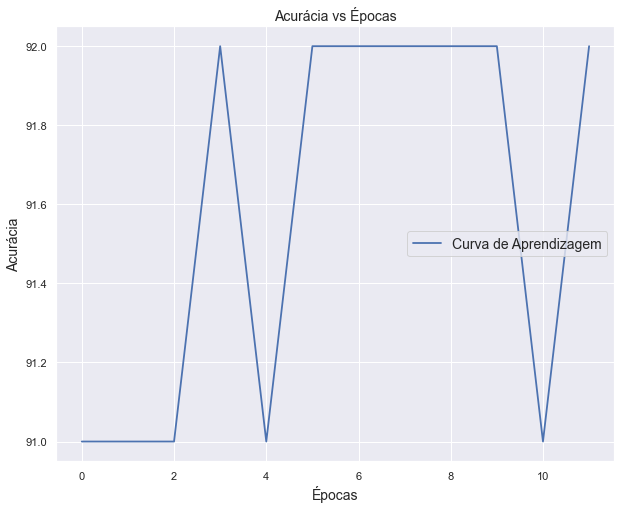

In [308]:
#Curva de aprendizado

plt.figure(figsize= (10,8))
plt.title('Acurácia vs Épocas', fontsize = 14)
plt.ylabel('Acurácia', fontsize = 14)
plt.xlabel('Épocas', fontsize = 14)
plt.plot(acurácia.round(2)*100, linewidth = 1.8, label = 'Curva de Aprendizagem')
plt.legend(fontsize = 14)

In [309]:
model.fit(predictors_scaled,target,
          validation_split = 0.20,
          epochs = 20,
          callbacks = [early_stopping])


Epoch 1/20
815/815 [==============================] - 2s 3ms/step - loss: 0.2091 - accuracy: 0.9268 - val_loss: 0.2925 - val_accuracy: 0.9181
Epoch 2/20
815/815 [==============================] - 2s 2ms/step - loss: 0.2071 - accuracy: 0.9268 - val_loss: 0.4056 - val_accuracy: 0.8950
Epoch 3/20
815/815 [==============================] - 2s 2ms/step - loss: 0.2041 - accuracy: 0.9289 - val_loss: 0.3398 - val_accuracy: 0.9038
Epoch 4/20
815/815 [==============================] - 2s 3ms/step - loss: 0.2021 - accuracy: 0.9295 - val_loss: 0.2994 - val_accuracy: 0.9128
Epoch 5/20
815/815 [==============================] - 2s 3ms/step - loss: 0.2004 - accuracy: 0.9294 - val_loss: 0.3099 - val_accuracy: 0.9158


In [310]:
predições = model.predict(predictors_scaled)

1019/1019 [==============================] - 1s 1ms/step


In [311]:
#Exemplo de aplicação

pd.DataFrame({ 
              'Probabilidade de Inadimplência':predições[:,0].round(2)*100,
              'Valor Real': np.where(target.iloc[:,0] ==1,'Inadimplente','Não Inadimplente')
}).head(20)

Probabilidade de Inadimplência        Valor Real
0                            100.0      Inadimplente
1                             38.0  Não Inadimplente
2                            100.0      Inadimplente
3                            100.0      Inadimplente
4                            100.0      Inadimplente
5                            100.0      Inadimplente
6                            100.0      Inadimplente
7                            100.0      Inadimplente
8                            100.0      Inadimplente
9                             98.0      Inadimplente
10                           100.0      Inadimplente
11                           100.0      Inadimplente
12                           100.0      Inadimplente
13                           100.0      Inadimplente
14                            11.0  Não Inadimplente
15                             0.0  Não Inadimplente
16                             8.0  Não Inadimplente
17                           100.0      Inadimplente
18                           100.0      Inadimplente
19                           100.0      Inadimplente

In [332]:
!pip install pydot

In [330]:
#Plot do Modelo

plot_model(model, to_file='model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
